# Behavior analysis
This analysis covers the foraging task in the physical setup. More information about that task can be found in the `TreadmillTracker` [repository](https://github.com/ckemere/TreadmillTracker).

Planned outline: develop each analysis for single session, then add batch feature
- Basic analysis: run as single session or batch mode
    - Harvest rate
    - Residence and travel time
    - Lick stats
- Patch dynamics: run as single session or batch mode
    - Reward rate vs. time in patch
    - Lick rate vs. time in patch
- Other analysis...

## Initial setup

### Imports

In [52]:
# Numerical tools
import numpy as np
import math

# Plotting tools
import matplotlib.pyplot as plt

# OS tools
from tempfile import TemporaryFile
import time
import os
import getpass

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util
import session
import plot
import analysis
import ephys

### Helper classes

In [3]:
# Create Plotter object
plotter = plot.Plotter()

# Create Google Drive interface
service = util.GoogleDriveService()

### Helper functions

In [19]:
def upload_figure(name, folder_id, fmt='pdf'):
    with TemporaryFile(suffix='.{}'.format(fmt)) as f:
        plt.savefig(f, format=fmt)
        drive_service.upload(file_stream=f,
                             filename=name,
                             folder_ids=folder_id,
                             mime_type='application/octet-stream',
                             chunk_size=1024*256*4,
                             verbose=True)

def get_permission(d):
    # Allow read/write permissions from/to directory
    password = getpass.getpass()
    command = 'sudo -S chmod 777 {}'.format(media_dir) # -S enables input from stdin
    os.system('echo {} | {}'.format(password, command))
    
def get_filepath(mouse_dir, day, overwrite=False):
    filepath = '/'.join([mouse_dir , 'sess_{:02d}.p'.format(day)])
    if overwrite:
        return filepath
    else:
        i = 0
        while os.path.isfile(filepath):
            i += 1
            filepath = '/'.join([mouse_dir, 'sess_{:02d}-{}.p'.format(day, i)])
        return filepath

def save_sessions(mouse_id, results_dir, overwrite=False, verbose=True):
    mouse_dir = '/'.join([results_dir, mouse_id])
    if not os.path.isdir(mouse_dir):
        try:
            os.mkdir(mouse_dir)
        except PermissionError:
            print('Need password for permission to write to {}'.format(mouse_dir))
            get_permission(mouse_dir)
    
    if verbose:
        print('Saving sessions for mouse {} to {}...'.format(mouse_id, mouse_dir), end=' ')
    for sess in sessions[mouse_id]:
        filepath = get_filepath(mouse_dir, sess.day, overwrite=overwrite)
        sess.save(filepath)
    if verbose:
        print('done.')
    
def load_sessions(mouse_id, results_dir, verbose=True):
    mouse_dir = '/'.join([results_dir, mouse_id])
    if verbose:
        print('Loading sessions for mouse {} from {}...'.format(mouse_id, mouse_dir), end=' ')
        
    sessions = []
    for filename in os.listdir(mouse_dir):
        try:
            filepath = '/'.join([mouse_dir, filename])
            sess = session.TTSession()
            sess.load(filepath)
            sessions.append(sess)
        except PermissionError:
            print('Need password for permission to read from {}'.format(mouse_dir))
            get_permission(mouse_dir)
    if verbose:
        print('done.')
    
    return sessions

## Single session analysis

### Load session

In [270]:
# Create results directory
folder_id = service.get_folder_ids(foldername='R001', 
                                   exact_match=True, 
                                   parent='track_task_analysis')

# Load data file
data_filename = 'R001_d34_2019-09-11-1435_log.txt'
load_fn = lambda x: np.loadtxt(x, delimiter=',')
data = util.bytes_to_object(service.download(filename=data_filename),
                            ob_type='numpy',
                            load_fn=load_fn)

# Load params file
params_filename = 'R001_d34_2019-09-11-1435_params.json'
params = util.bytes_to_object(service.download(filename=params_filename),
                              ob_type='json')

# Create Session objects
sess = session.TTSession(data, params)

Exception ignored in: <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 36562), raddr=('172.217.12.74', 443)>
Exception ignored in: <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 48492), raddr=('172.217.9.10', 443)>


### Session summary

In [271]:
T = sess.analyzed_time
t_patch = sess.get_patch_times()
#t_lick = analysis.get_lick_decisions(sess)
t_lick = sess.get_lick_times()
t_motor = sess.get_motor_times()

100% complete...
File sucessfully uploaded.


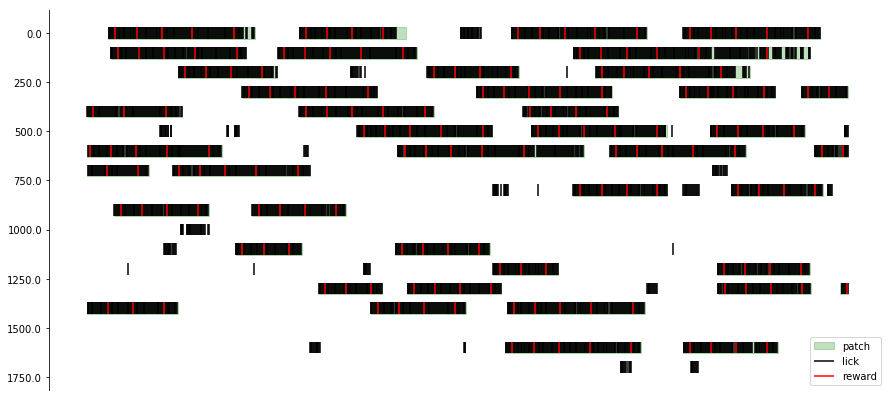

In [272]:
plotter.plot_session_summary(T=T,
                             t_patch=t_patch,
                             t_lick=t_lick,
                             t_motor=t_motor,
                             dt_chunk=100,
                             figsize=(15, 7))
save_figure('{:02d}_summary.png'.format(sess.day), fmt='png')

### Harvest rate

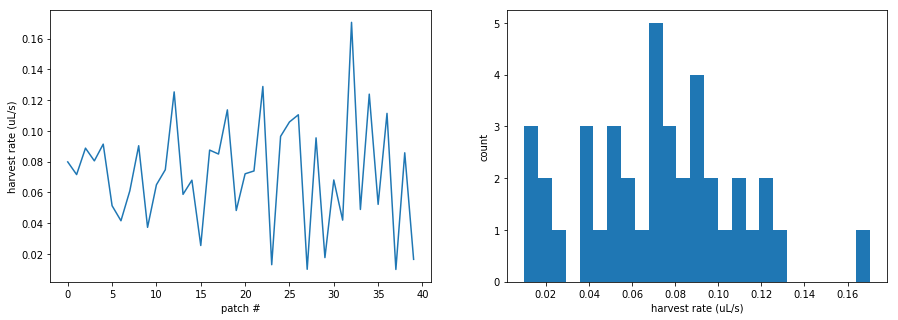

In [273]:
# Grab harvest rate over sessions
hr_obs = sess.get_harvest_rate(metric='observed', per_patch=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rate over patches
ax[0].plot(hr_obs)
ax[0].set_xlabel('patch #')
ax[0].set_ylabel('harvest rate (uL/s)')

# Plot distribution of harvest rates
ax[1].hist(hr_obs, bins=25)
ax[1].set_xlabel('harvest rate (uL/s)')
ax[1].set_ylabel('count');

### Residence and travel times

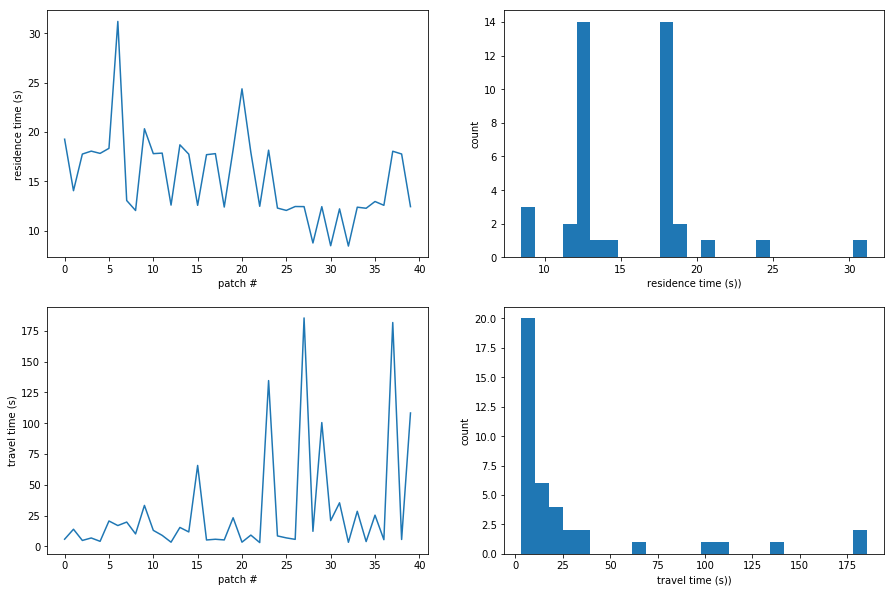

In [274]:
# Get residence and travel times
t_p_obs = sess.get_patch_durations()
t_t_obs = sess.get_interpatch_durations()

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot residence time over patches
ax[0, 0].plot(t_p_obs)
ax[0, 0].set_xlabel('patch #')
ax[0, 0].set_ylabel('residence time (s)')

# Plot distribution of residence times
ax[0, 1].hist(t_p_obs, bins=25)
ax[0, 1].set_xlabel('residence time (s))')
ax[0, 1].set_ylabel('count')

# Plot travel time over patches
ax[1, 0].plot(t_t_obs)
ax[1, 0].set_xlabel('patch #')
ax[1, 0].set_ylabel('travel time (s)')

# Plot distribution of travel times
ax[1, 1].hist(t_t_obs, bins=25)
ax[1, 1].set_xlabel('travel time (s))')
ax[1, 1].set_ylabel('count');

### Combined data

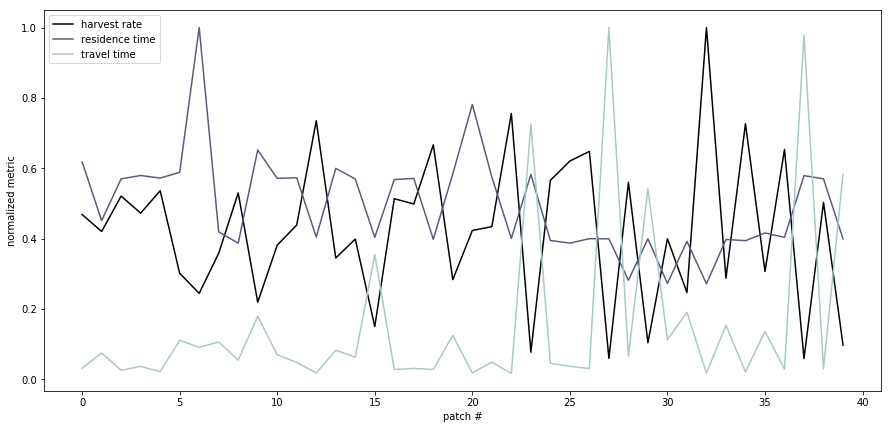

In [275]:
# Plot normalized harvest rate, residence time, and travel time per patch
fig, ax = plt.subplots(figsize=(15, 7))
cmap = plt.get_cmap('bone')

ax.plot(hr_obs/np.max(hr_obs), color=cmap(0.0), label='harvest rate')
ax.plot(t_p_obs/np.max(t_p_obs), color=cmap(0.4), label='residence time')
ax.plot(t_t_obs/np.max(t_t_obs), color=cmap(0.75), label='travel time')
ax.set_xlabel('patch #')
ax.set_ylabel('normalized metric')
ax.legend();

### Task engagement

#### By travel time

In [ ]:
# Generate models
linear_normal = Gaussian()
linear_normal.fit(t_t_obs)
log_normal = LogGaussian()
log_normal.fit(t_t_obs)
poisson = Poisson(0)
poisson.fit(t_t_obs, interevent=True)

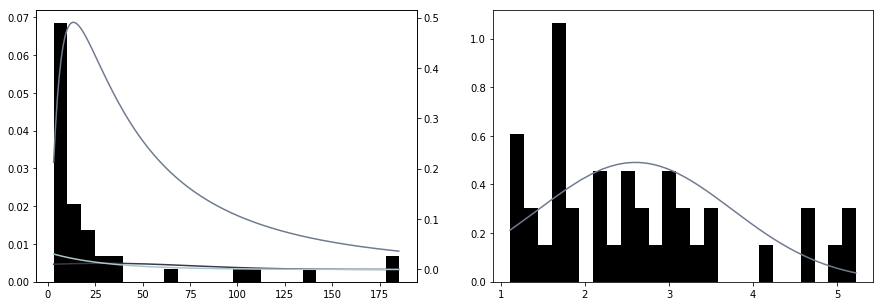

In [451]:
# Plot distribution of travel time
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t = np.arange(np.min(t_t_obs), np.max(t_t_obs))

# Linear space
ax[0].hist(t_t_obs, bins=25, density=True, color=cmap(0.0))
ax2 = ax[0].twinx()
ax2.plot(t, linear_normal._pdf(t), color=cmap(0.25))
ax2.plot(t, log_normal._pdf(t), color=cmap(0.50))
ax2.plot(t, poisson._pdf(t), color=cmap(0.75))

# Log space
ax[1].hist(np.log(t_t_obs), bins=25, density=True, color=cmap(0.0))
ax[1].plot(np.log(t), log_normal._pdf(t), color=cmap(0.50))

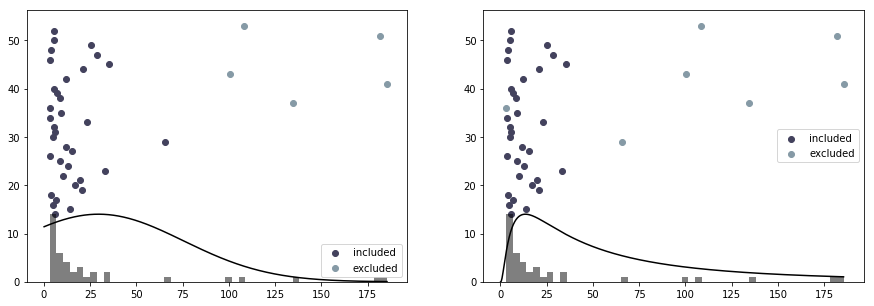

In [454]:
# Choose cutoffs
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = plt.get_cmap('bone')
tt = np.linspace(0.1, t_t_obs.max(), num=1000) # for pdf
thresh = 0.80 # percentile

# Iterate over models
for i, model in enumerate([linear_normal, log_normal]):
    # Get indices of included times
    idx = model.test_statistic(t_t_obs, 
                               distribution='f', 
                               test='<=', 
                               q=thresh)
    
    # Calculate distribution of times within model
    counts, bins, _ = ax[i].hist(t_t_obs, bins=50, 
                                 color=cmap(0.0), alpha=0.5)
    pdf = model.pdf(tt)
    
    # Plot distributions and results
    ax[i].plot(tt, pdf/pdf.max()*counts.max(), color=cmap(0.0))
    ax[i].scatter(t_t_obs[idx], np.arange(len(t_t_obs))[idx] + np.max(counts), 
                color=cmap(0.3), label='included')
    ax[i].scatter(t_t_obs[~idx], np.arange(len(t_t_obs))[~idx] + np.max(counts), 
                color=cmap(0.6), label='excluded')

    ax[i].legend()

## Batch analysis

### Load sessions

In [21]:
# Settings
mouse_ids = ['R001', 'R002', 'R003', 'R004']
session_range = [1, 50]
media_dir = '/media/james/data/foraging/linear_track/'

In [29]:
# Load sessions
sessions = {}
load_fn = lambda x: np.loadtxt(x, delimiter=',')
for mouse_id in mouse_ids:
    # Load all local sessions
    print('Loading local sessions for mouse {}...'.format(mouse_id), end=' ')
    sessions[mouse_id] = load_sessions(mouse_id, media_dir, verbose=False)
    print('done.')
    
    # Get all session IDs for comparison later
    session_ids = [sess.params['Info']['Session'] for sess in sessions[mouse_id]]
    
    # Get parent folder ID
    parent_id = service.get_folder_ids(foldername=mouse_id,
                                       unique=True,
                                       exact_match=True,
                                       parent='track_data')[0]
    
    # Get param file IDs and filenames
    param_fids = service.get_file_ids(filename='.json',
                                      exact_match=False,
                                      parent=parent_id)
    param_filenames = service.get_file_metadata(file_ids=param_fids, fields='name')
    param_filenames = [f['name'] for f in param_filenames]
    
    # Find corresponding log file IDs
    suffix = '_params.json'
    log_filenames = [f[:-len(suffix)] + '_log.txt' for f in param_filenames]
    log_fids = []
    for log_filename in log_filenames:
        log_fids.append(service.get_file_ids(filename=log_filename,
                                             exact_match=True,
                                             parent=parent_id)[0])

    # Load param and data files in session range that are not already loaded
    print('Downloading sessions for mouse %s:' % mouse_id)
    for param_fid, log_fid in zip(param_fids, log_fids):
        params = util.bytes_to_object(service.download(file_id=param_fid), ob_type='json')
        session_id = params['Info'].get('Session', 0)
        if ((session_id >= session_range[0]) 
            and (session_id <= session_range[1])
            and (session_id not in session_ids)):
            print('Downloading session %d...' % session_id, end=' ')
            log = util.bytes_to_object(service.download(file_id=log_fid),
                                       ob_type='numpy', 
                                       load_fn=load_fn)
            sessions[mouse_id].append(session.TTSession(log, params))
            print('done.')
   
    print()

Loading local sessions for mouse R001... done.

Loading local sessions for mouse R002... done.

Loading local sessions for mouse R003... done.

Loading local sessions for mouse R004... done.



In [23]:
# Save downloaded sessions
for mouse_id in mouse_ids:
    save_sessions(mouse_id, media_dir, overwrite=True)

Saving sessions for mouse R001 to /media/james/data/foraging/linear_track//R001... done.
Saving sessions for mouse R002 to /media/james/data/foraging/linear_track//R002... done.
Saving sessions for mouse R003 to /media/james/data/foraging/linear_track//R003... done.
Saving sessions for mouse R004 to /media/james/data/foraging/linear_track//R004... done.


In [30]:
# Get days for faster downstream processing
days = {}
for mouse_id in mouse_ids:
    days[mouse_id] = [sess.day for sess in sessions[mouse_id]]

### Harvest rate

In [31]:
# Grab harvest rate over sessions
hr_obs = {} # observed rate
hr_max = {} # maximum rate given leaving decisions
hr_opt = {} # optimal rate (MVT) given environment
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    hr_obs[mouse_id] = []
    hr_max[mouse_id] = []
    hr_opt[mouse_id] = []

    for sess in sessions[mouse_id]:
        print('Processing session %d...' % sess.day, end=' ')
        try:
            hr_obs[mouse_id].append(sess.get_harvest_rate(metric='observed', per_patch=True))
            #hr_max[mouse_id].append(sess.get_harvest_rate(metric='max', per_patch=True))
            #hr_opt[mouse_id].append(sess.get_harvest_rate(metric='optimal', per_patch=True))
            print('done.')
        except IndexError as w: # unanalyzable session
            print(w)
            hr_obs[mouse_id].append(np.array([np.nan]))
            #hr_max[mouse_id].append(np.array([np.nan]))
            #hr_opt[mouse_id].append(np.array([np.nan]))

    print()    

Analyzing mouse R001:
Processing session 32... done.
Processing session 12... done.
Processing session 27... done.
Processing session 35... done.
Processing session 8... done.
Processing session 9... done.
Processing session 36... done.
Processing session 15... done.
Processing session 21... done.
Processing session 28... done.
Processing session 10... done.
Processing session 13... done.
Processing session 5... done.
Processing session 31... done.
Processing session 3... done.
Processing session 18... done.
Processing session 39... done.
Processing session 30... done.
Processing session 38... done.
Processing session 16... done.
Processing session 2... index 0 is out of bounds for axis 0 with size 0
Processing session 33... done.
Processing session 26... done.
Processing session 17... done.
Processing session 22... done.
Processing session 19... done.
Processing session 40... done.
Processing session 11... done.
Processing session 34... done.
Processing session 37... done.
Processing 

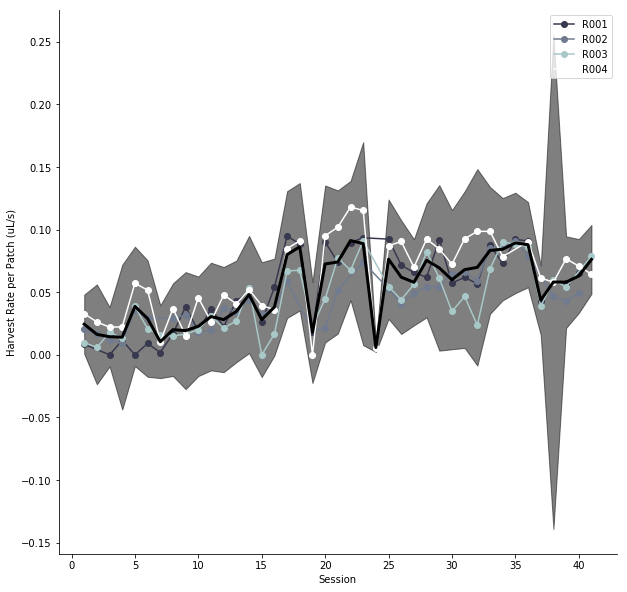

In [32]:
# Plot results
plotter.set_cmap('bone')
plotter.plot_harvest_rates(days, hr_obs, plot_traces=True, err='std', err_plot='fill', c=0.0)
plt.legend();

### Residence and travel time

In [33]:
# Grab patch residence and travel times
t_p_obs = {}
t_p_opt = {}
t_t_obs = {}
t_t_opt = {}
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    t_p_obs[mouse_id] = []
    t_p_opt[mouse_id] = []
    t_t_obs[mouse_id] = []
    t_t_opt[mouse_id] = []

    for sess, day in zip(sessions[mouse_id], days[mouse_id]):
        print('Processing session %d... ' % day, end=' ')

        try:
            t_p_obs[mouse_id].append(sess.get_patch_durations())
            t_t_obs[mouse_id].append(sess.get_interpatch_durations())   
        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            t_p_obs[mouse_id].append(np.asarray([np.nan]))
            t_t_obs[mouse_id].append(np.asarray([np.nan]))
            
        try:
            _, _, t_p_opt_, t_t_opt_ = sess.get_harvest_rate(metric='optimal', return_all=True)
            t_p_opt[mouse_id].append(np.asarray([t_p_opt_]))
            t_t_opt[mouse_id].append(np.asarray([t_t_opt_]))
            print('done.')
        except (UserWarning, IndexError) as w: # no reward decay params or unanalyzable session
            print(w)
            t_p_opt[mouse_id].append(np.asarray([np.nan]))
            t_t_opt[mouse_id].append(np.asarray([np.nan]))

    print()

Analyzing mouse R001:
Processing session 32...  done.
Processing session 12...  Reward depletion parameters not specified.
Processing session 27...  done.
Processing session 35...  done.
Processing session 8...  Reward depletion parameters not specified.
Processing session 9...  Reward depletion parameters not specified.
Processing session 36...  done.
Processing session 15...  Reward depletion parameters not specified.
Processing session 21...  done.
Processing session 28...  done.
Processing session 10...  Reward depletion parameters not specified.
Processing session 13...  Reward depletion parameters not specified.
Processing session 5...  Reward depletion parameters not specified.
Processing session 31...  done.
Processing session 3...  Reward depletion parameters not specified.
Processing session 18...  Reward depletion parameters not specified.
Processing session 39...  done.
Processing session 30...  done.
Processing session 38...  done.
Processing session 16...  Reward depletio

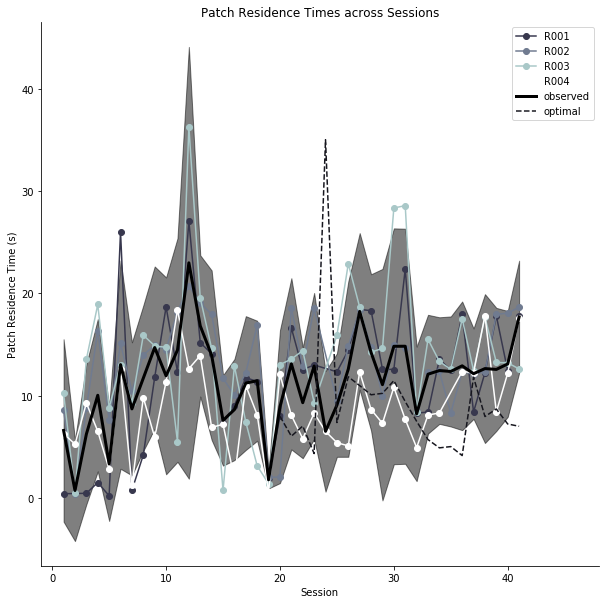

In [34]:
plotter.set_cmap('bone')
plotter.plot_residence_times(days, t_p_obs, t_p_opt, plot_traces=True, err='std', err_plot='fill', c=0.0)

### Decay rate variability

In [35]:
# Get decay rate of each session
tau = {}
for mouse_id in mouse_ids:
    tau[mouse_id] = []
    for sess in sessions[mouse_id]:
         # Get tau if available
        try:
            tau[mouse_id].append(sess.params['Reward']['tau'])
        except KeyError:
            tau[mouse_id].append(-1)  

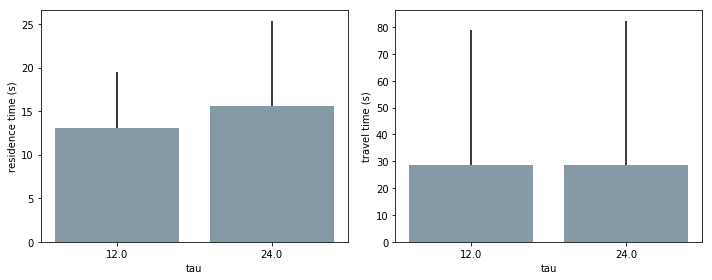

In [36]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Collect patch data by decay rate
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_p_err, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot residence times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_p_err[plot_idx]])
ax[0].bar(np.arange(len(plot_idx)), 
          t_p_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[0].set_xticks(np.arange(len(plot_idx)))
ax[0].set_xticklabels(tau_plot[plot_idx])
ax[0].set_xlabel('tau')
ax[0].set_ylabel('residence time (s)')

# Collect patch data by decay rate
t_t_plot, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_t_err, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot travel times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_t_err[plot_idx]])
ax[1].bar(np.arange(len(plot_idx)), 
          t_t_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[1].set_xticks(np.arange(len(plot_idx)))
ax[1].set_xticklabels(tau_plot[plot_idx])
ax[1].set_xlabel('tau')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

In [37]:
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)

<BarContainer object of 2 artists>

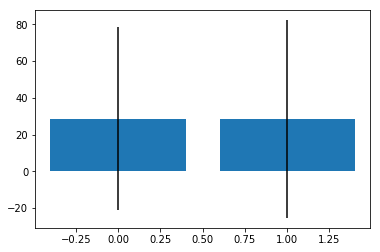

In [38]:
# Collect travel time data by decay rate
data, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
err, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot results
plot_idx = np.argwhere(tau_ > 0.0).flatten()
plt.bar(np.arange(len(plot_idx)), data[plot_idx], yerr=err[plot_idx])

### Inclusion criteria
Filter residence and travel times based on inclusion criteria.

#### Get experimental conditions

In [108]:
# Get unique experimental conditions
cond = {} # conditions of each session
vals = [] # hash values of condition
vals_cond = {} # hash value --> condition
cond_params = {} # condition --> parameters
i = 0
for mouse_id in mouse_ids:
    cond[mouse_id] = []
    for sess in sessions[mouse_id]:
         # Get tau if available
        try:
            tau = sess.params['Reward']['tau']
        except KeyError:
            tau = -1
        
        # Get task type
        task = sess.params['Info']['Task']
        
        # Get unique value
        val = hash(str(tau) + task)
        if val in vals:
            # Condition already found. Find appropriate ID.
            cond[mouse_id].append(vals_cond[val])
        else:
            # Condition is new. Add to dict.
            vals.append(val)
            vals_cond[val] = i
            cond_params[i] = [tau, task]
            cond[mouse_id].append(vals_cond[val])
            i += 1
            
print(cond_params)

{0: [12.0, 'LinearTrack'], 1: [-1, 'LinearTrack'], 2: [24.0, 'LinearTrack'], 3: [12.0, 'LinearTrackBarriers']}


In [121]:
data = {}
cond_ = {}
for mouse_id in mouse_ids:
    data[mouse_id], cond_[mouse_id] = \
        util.get_patch_statistics(t_t_obs[mouse_id],
                                  ids=cond[mouse_id],
                                  return_all=True)

#### Distribution models

In [110]:
# For each set of conditions, create a new model distribution
linear_normal = {}
log_normal = {}
exp = {}
for mouse_id in mouse_ids:
    print('Mouse {}:'.format(mouse_id))
    
    linear_normal[mouse_id] = {}
    log_normal[mouse_id] = {}
    exp[mouse_id] = {}
    for cond_i in np.unique(cond_[mouse_id]):
        print('tau = {:2f}, task = {}:'.format(*cond_params[cond_i]))

        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()

        # Fit linear normal model
        model = ephys.Gaussian()
        model.fit(data[mouse_id][idx])
        mu = model.params['mu']
        std = model.params['sigma']
        p = model.goodness_of_fit(data[mouse_id][idx], method='SW').pvalue
        print('Linear-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
        linear_normal[mouse_id][cond_i] = model

        # Fit log normal model
        model = ephys.LogGaussian()
        model.fit(data[mouse_id][idx])
        mu = model.params['mu']
        std = model.params['sigma']
        p = model.goodness_of_fit(data[mouse_id][idx], method='SW').pvalue
        print('Log-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
        log_normal[mouse_id][cond_i] = model

        # Fit exponential model
        model = ephys.Exponential()
        model.fit(data[mouse_id][idx])
        lam = model.params['lam']
        p = model.goodness_of_fit(data[mouse_id][idx]).pvalue
        print('Exponential: lambda={:2f}, p={:5e}'.format(lam, p))
        exp[mouse_id][cond_i] = model

        print()
    print()

Mouse R001:
tau = 12.000000, task = LinearTrack:
Linear-normal: mu=24.498226, std=52.517174, p=1.795653e-34
Log-normal: mu=2.381470, std=1.094610, p=5.003618e-15
Exponential: lambda=0.040819, p=2.971065e-23

tau = -1.000000, task = LinearTrack:
Linear-normal: mu=75.640013, std=120.579477, p=1.240130e-25
Log-normal: mu=3.415936, std=1.362037, p=1.672810e-05
Exponential: lambda=0.013221, p=1.038226e-10

tau = 24.000000, task = LinearTrack:
Linear-normal: mu=29.807235, std=56.435233, p=1.458557e-24
Log-normal: mu=2.649198, std=1.068456, p=1.702803e-09
Exponential: lambda=0.033549, p=1.122854e-11

tau = 12.000000, task = LinearTrackBarriers:
Linear-normal: mu=33.199713, std=34.516101, p=3.905321e-17
Log-normal: mu=3.099702, std=0.887822, p=6.882601e-04
Exponential: lambda=0.030121, p=2.160762e-03


Mouse R002:
tau = 12.000000, task = LinearTrack:
Linear-normal: mu=33.194481, std=50.879448, p=7.265161e-30
Log-normal: mu=2.888389, std=1.033157, p=1.167159e-07
Exponential: lambda=0.030125, p=

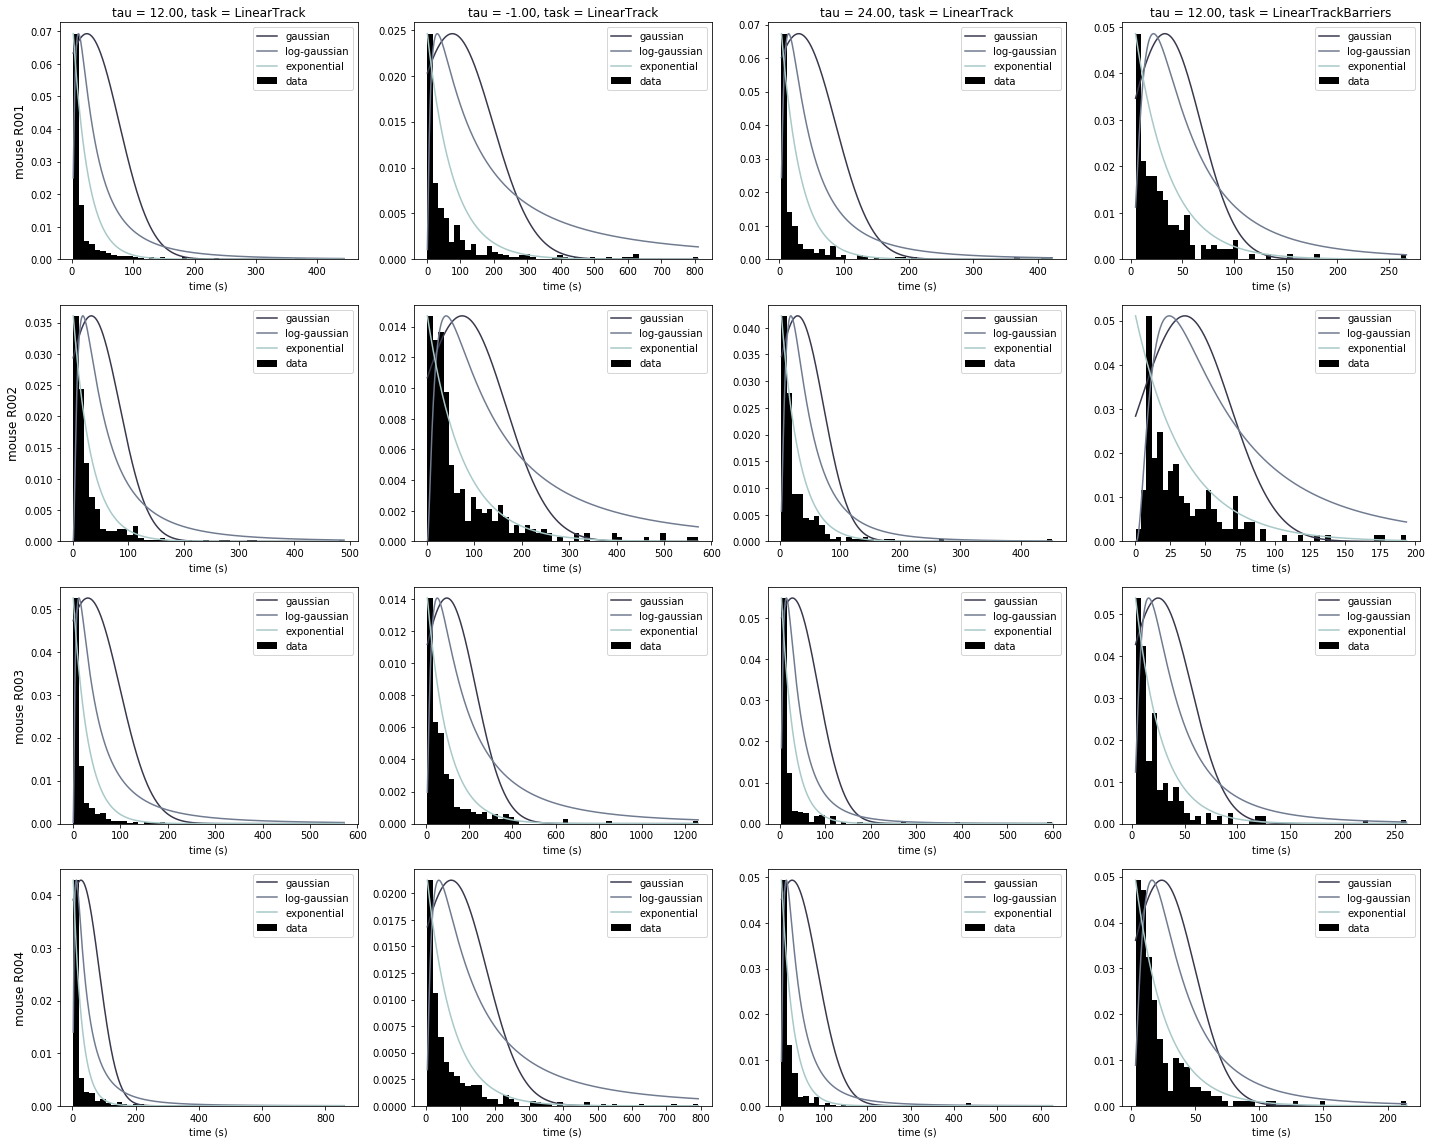

In [126]:
# Plot fits
ncols = len(cond_params) # number of conditions
nrows = len(mouse_ids)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
for i, mouse_id in enumerate(mouse_ids):
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()

        # Plot histogram
        ax_ = ax[i, j]
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')

        # Plot model fits
        t = np.linspace(data[mouse_id][idx].min(), data[mouse_id][idx].max(), 1000)
        for k, model in enumerate([linear_normal[mouse_id][cond_i], 
                                   log_normal[mouse_id][cond_i], 
                                   exp[mouse_id][cond_i]]):
            pdf = model.pdf(t)
            scale = vals.max()/pdf.max()
            ax_.plot(t, scale*pdf,
                     color=cmap(0.25*(k+1)),
                     label=model.name)

        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}'.format(mouse_id), size='large')
        ax_.set_xlabel('time (s)')
        ax_.legend()
    
plt.tight_layout()

Models for mouse R001


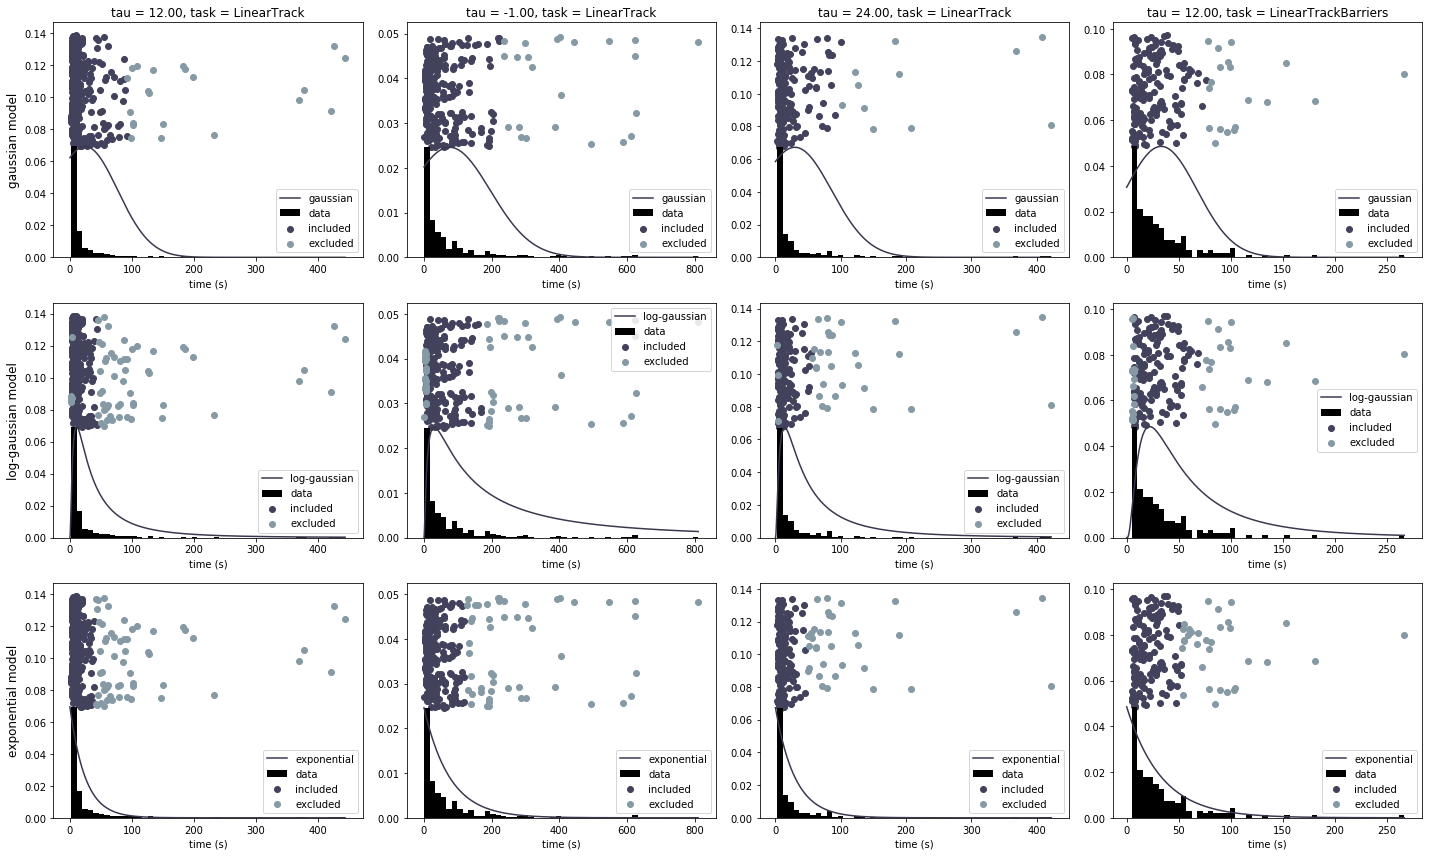

In [137]:
# Choose cutoffs
mouse_id = 'R001'
ncols = len(cond_params) # number of conditions
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
thresh = 0.80 # percentile

# Iterate over models
print('Models for mouse {}'.format(mouse_id))
for i, cond_i in enumerate(np.unique(cond_[mouse_id])):
    # Find indices
    idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
    t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf
    
    for j, model in enumerate([linear_normal[mouse_id][cond_i], 
                               log_normal[mouse_id][cond_i], 
                               exp[mouse_id][cond_i]]):
        # Plot histogram
        ax_ = ax[j, i]
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')
        
        # Get indices of included times
        method = getattr(model, 'test_statistic', None)
        if method is not None and callable(method):
            idx_include = model.test_statistic(data[mouse_id][idx], 
                                               distribution='f', 
                                               test='<=', 
                                               q=thresh)
        else:
            idx_include = (data[mouse_id][idx] <= model._inv_cdf(thresh))

        # Plot pdf
        pdf = model.pdf(t)
        scale = vals.max()/pdf.max()
        ax_.plot(t, scale*pdf,
                 color=cmap(0.25),
                 label=model.name)

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
        ax_.scatter(data[mouse_id][idx][idx_include], 
                    x[idx_include], 
                    color=cmap(0.3), 
                    label='included')
        ax_.scatter(data[mouse_id][idx][~idx_include], 
                    x[~idx_include], 
                    color=cmap(0.6), 
                    label='excluded')

        # Format plot
        if (j == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (i == 0):
            # Row header
            ax_.set_ylabel('{} model'.format(model.name), size='large')
        ax_.set_xlabel('time (s)')
        ax_.legend()
        
plt.tight_layout()

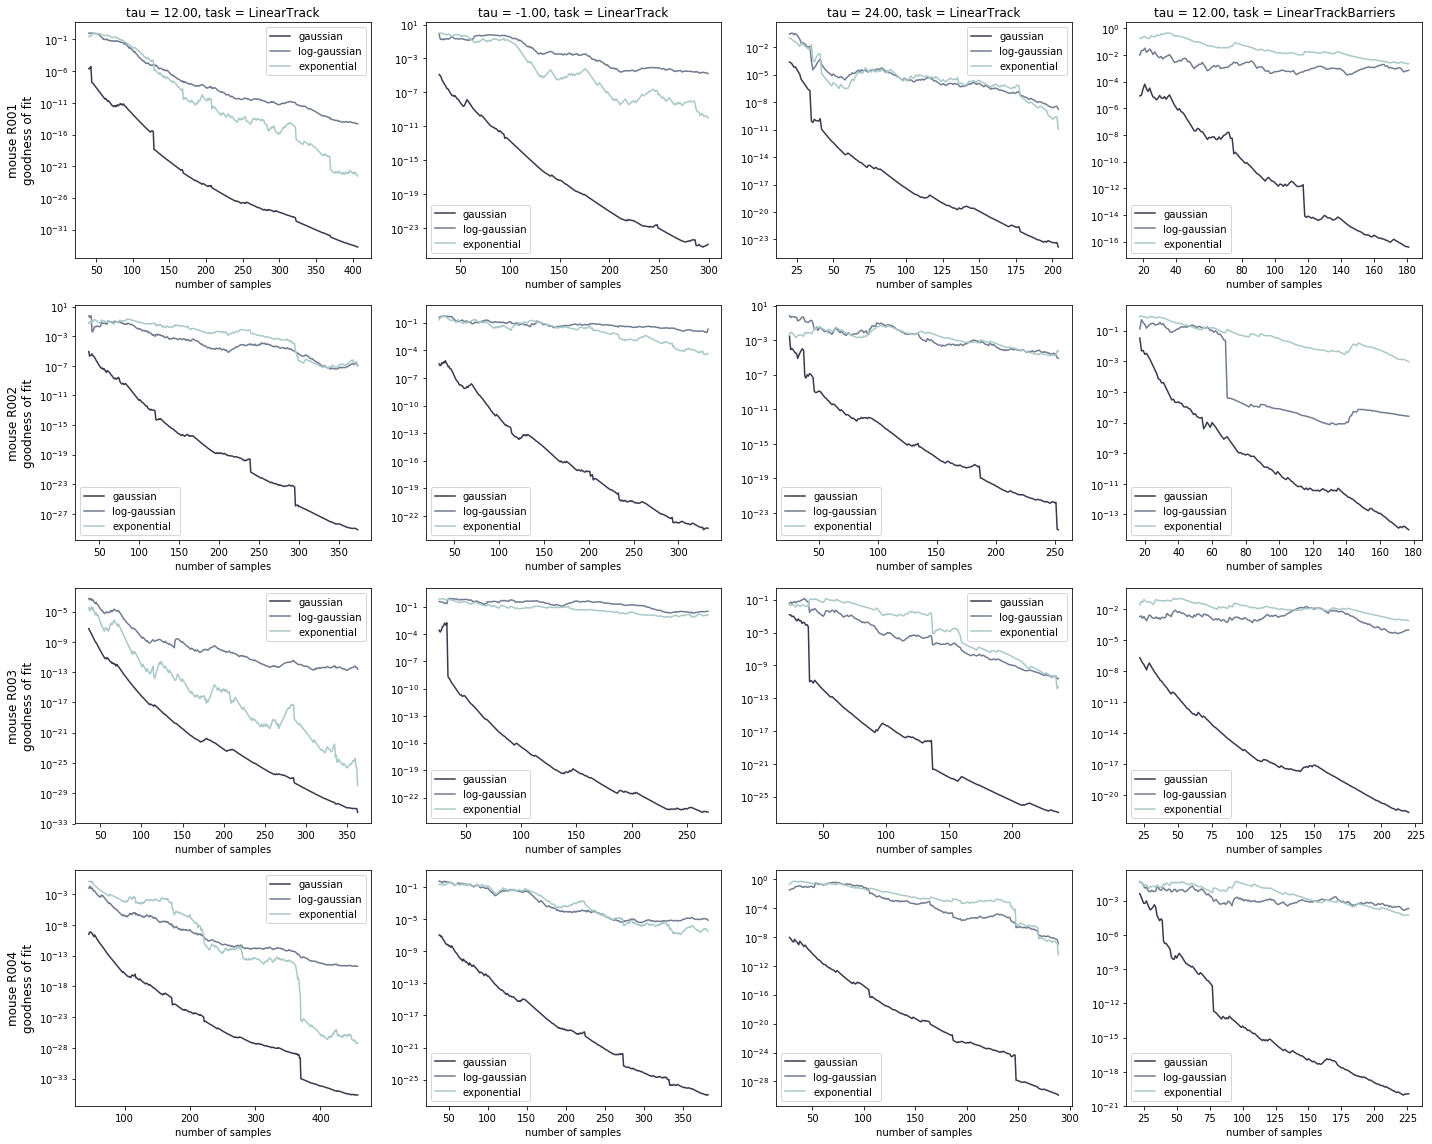

In [143]:
# Next idea: drop travel times until a best match for a normal distribution is found
ncols = len(cond_params) # number of conditions
nrows = len(mouse_ids) # number of animals
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
opt_samples = {}
min_data = 0.10 # minimum fraction of data ot include

# Iterate over animals, models
for i, mouse_id in enumerate(mouse_ids):
    # Placeholder
    opt_samples[mouse_id] = {}
    
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        data_i = data[mouse_id][idx]
        
        # Placeholder
        opt_samples[mouse_id][cond_i] = {}
        
        # Axis setup
        ax_ = ax[i, j]
        n_range = np.arange(int(min_data*len(data_i)), len(data_i)+1)
        
        for k, Model in enumerate([ephys.Gaussian, ephys.LogGaussian, ephys.Exponential]):
            # Find p-values of fitting subsets of data
            model = Model()
            p = np.zeros([len(n_range)])
            for m, n in enumerate(n_range):
                model.fit(data_i[:n])
                p[m] = model.goodness_of_fit(data_i[:n]).pvalue

            # Plot p-values vs. number of samples
            ax_.plot(n_range, p, 
                     color=cmap(0.25*(k+1)),
                     label=model.name)

            # Save argmax
            opt_samples[mouse_id][cond_i][model.name] = n_range[np.argmax(p)]
        
        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}\ngoodness of fit'.format(mouse_id), size='large')
        ax_.set_xlabel('number of samples')
        ax_.set_yscale('log')
        ax_.legend()     
        
plt.tight_layout()

Models for mouse R001


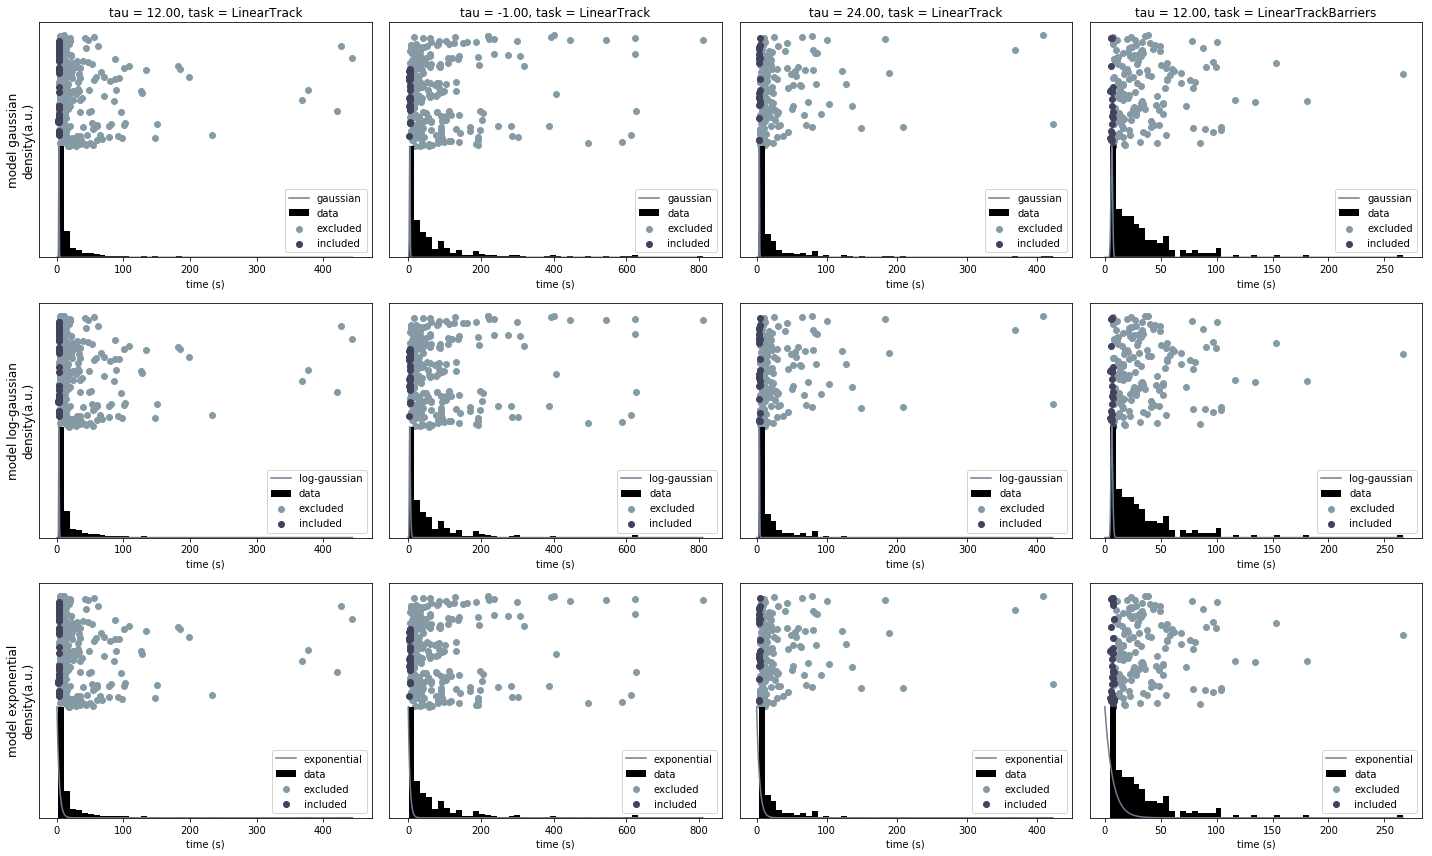

In [146]:
# Choose cutoffs by maximizing goodness of fit via above
mouse_id = 'R001'
ncols = len(cond_params)
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Iterate over models
print('Models for mouse {}'.format(mouse_id))
for i, cond_i in enumerate(np.unique(cond_[mouse_id])):
    # Find indices
    idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
    t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf
    
    for j, Model in enumerate([ephys.Gaussian, ephys.LogGaussian, ephys.Exponential]):
        # Plot histogram
        ax_ = ax[j, i]
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')
        
        # Get indices of included times
        model = Model()
        n_samples = opt_samples[mouse_id][cond_i][model.name]
        model.fit(np.sort(data[mouse_id][idx])[:n_samples])
        idx_include = np.zeros(len(idx), dtype=np.bool)
        idx_include[np.argsort(data[mouse_id][idx])[:n_samples]] = True
        
        # Plot pdf
        pdf = model.pdf(t)
        scale = vals.max()/pdf.max()
        ax_.plot(t, scale*pdf,
                 color=cmap(0.50),
                 label=model.name)

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
        ax_.scatter(data[mouse_id][idx][~idx_include], 
                    x[~idx_include], 
                    color=cmap(0.6), 
                    label='excluded')
        ax_.scatter(data[mouse_id][idx][idx_include], 
                    x[idx_include], 
                    color=cmap(0.3), 
                    label='included')

        # Format plot
        if (j == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (i == 0):
            # Row header
            ax_.set_ylabel('model {}\ndensity(a.u.)'.format(model.name), size='large')
        ax_.set_yticks([])
        ax_.set_xlabel('time (s)')
        #ax_.set_xlim([-10, 200])
        ax_.legend()
        
plt.tight_layout()

#### Classification models

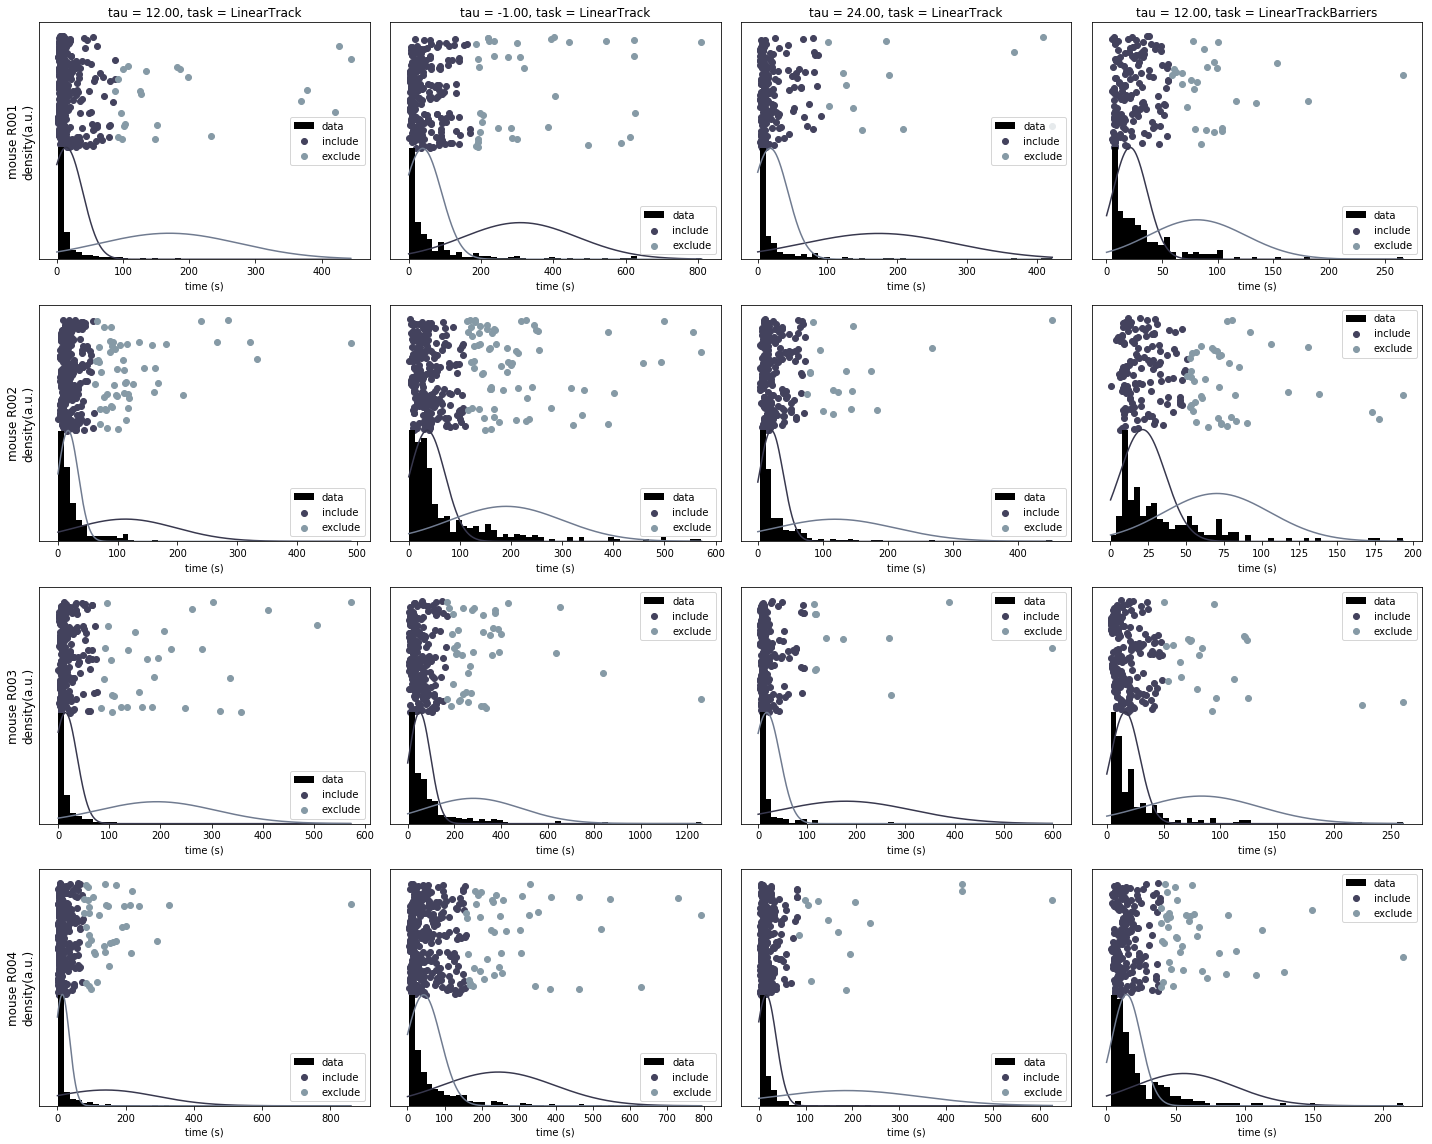

In [148]:
# Choose cutoffs by fitting to GMM with k=2
k = 2
ncols = len(cond_params)
nrows = len(mouse_ids)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Iterate over animals, models
gmm = {}
for i, mouse_id in enumerate(mouse_ids):
    # Placeholder
    gmm[mouse_id] = {}
    
    for j, cond_i in enumerate(np.unique(cond_[mouse_id])):
        # Find indices
        idx = np.argwhere(cond_[mouse_id] == cond_i).flatten()
        t = np.linspace(0.1, data[mouse_id][idx].max(), num=1000) # for pdf

        # Plot histogram
        ax_ = ax[i, j]
        vals, bins, _ = ax_.hist(data[mouse_id][idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')

        # Get fit GMM
        model = ephys.GaussianMixture(k=k)
        model.fit(data[mouse_id][idx], verbose=False)
        labels = model.predict(data[mouse_id][idx])
        gmm[mouse_id][cond_i] = model

        # Find maximum pdf value for scale
        max_val = 0.0
        scale = 1.0
        for k_ in range(k):
            pdf = model._models[k_].pdf(t)
            if pdf.max() > max_val:
                scale = vals.max()/pdf.max()
                max_val = pdf.max()
                
        # Plot pdf of each Gaussian in mixture
        for k_ in range(k):  
            pdf = model._models[k_].pdf(t)
            ax_.plot(t, scale*pdf,
                     color=cmap(0.25*(k_+1)))

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[mouse_id][idx]))
        label_include = np.argmin(model.params['mu'])
        idx_include = (labels == label_include)
        ax_.scatter(data[mouse_id][idx][idx_include], 
                    x[idx_include], 
                    color=cmap(0.30),
                    label='include')
        ax_.scatter(data[mouse_id][idx][~idx_include], 
                    x[~idx_include], 
                    color=cmap(0.60),
                    label='exclude')

        # Format plot
        if (i == 0):
            # Column header
            ax_.set_title('tau = {:.2f}, task = {}'.format(*cond_params[cond_i]), size='large')
        if (j == 0):
            # Row header
            ax_.set_ylabel('mouse {}\ndensity(a.u.)'.format(mouse_id), size='large')
        ax_.set_yticks([])
        ax_.set_xlabel('time (s)')
        #ax_.set_xlim([-10, 200])
        ax_.legend()
        
plt.tight_layout()

Now let's re-plot the travel time and residence time results with filtered data. From the above plot, it looks like fitting a GMM with two components gives reasonable results.

Remember that the underlying code in `Session.get_patch_durations()` and `Session.get_interpatch_durations()` already pairs each residence time with the subsequent travel time (with the idea that residence time is informed by the anticipated subsequent travel time). Thus if we filter by travel times, we can simply use the same indices to filter the residence times, knowing that they will be matched.

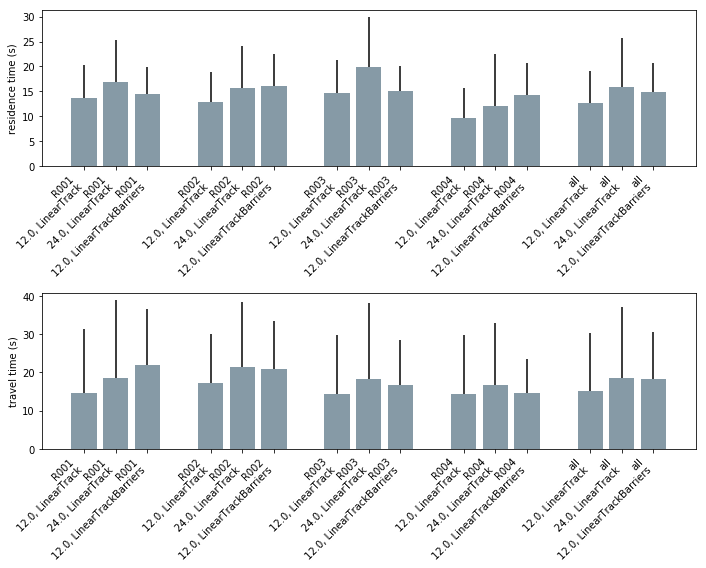

In [212]:
# Plot results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
cmap = plt.get_cmap('bone')
exclude_cond = [1]

# Filter data by inclusion criteria
t_p_filt = {}
t_t_filt = {}
cond_filt = {}
for i, mouse_id in enumerate(mouse_ids):
    # Get data
    t_t_, cond_1 = util.get_patch_statistics(t_t_obs[mouse_id],
                                            ids=cond[mouse_id],
                                            return_all=True)
    t_p_, cond_2 = util.get_patch_statistics(t_p_obs[mouse_id],
                                            ids=cond[mouse_id],
                                            return_all=True)
    assert (cond_1 == cond_2).all()
    cond_ = cond_1
    
    # Iterate over experimental conditions
    t_t_filt_ = []
    t_p_filt_ = []
    cond_filt_ = []
    cond_iters = np.unique(cond_)[~np.isin(np.unique(cond_), exclude_cond)]
    for j, cond_i in enumerate(cond_iters):
        # Find indices
        idx = np.argwhere(cond_ == cond_i).flatten()
        
        # Get inclusion labels
        labels = gmm[mouse_id][cond_i].predict(t_t_[idx])
        label_include = np.argmin(gmm[mouse_id][cond_i].params['mu'])
        idx_include = (labels == label_include)
        
        # Keep only included data
        t_t_filt_.append(t_t_[idx][idx_include])
        t_p_filt_.append(t_p_[idx][idx_include])
        cond_filt_.append(cond_[idx][idx_include])
        
    # Stack data
    t_t_filt[mouse_id] = np.hstack(t_t_filt_)
    t_p_filt[mouse_id] = np.hstack(t_p_filt_)
    cond_filt[mouse_id] = np.hstack(cond_filt_)

    for j, filt_data in enumerate([t_p_filt, t_t_filt]):
        # Get patch statistics by experimental condition
        t_plot, cond_plot = util.get_patch_statistics(filt_data[mouse_id], 
                                            ids=cond_filt[mouse_id], 
                                            method='mean', 
                                            return_all=False)
        t_err, cond_plot = util.get_patch_statistics(filt_data[mouse_id], 
                                            ids=cond_filt[mouse_id], 
                                            method='std', 
                                            return_all=False)

        # Plot residence times
        x = np.arange(len(cond_plot)) + i*(len(cond_plot) + 1)
        yerr = np.vstack([np.zeros(len(t_err)), t_err])
        ax[j].bar(x, 
                  t_plot, 
                  yerr=yerr,
                  color=cmap(0.60))

        # Format axis
        if (i == 0):
            ax[j].set_xticks([]) # clear default ticks
        xticks = ax[j].get_xticks()
        ax[j].set_xticks(list(xticks) + list(x))
        xtick_labels = [label._text for label in ax[j].get_xticklabels()
                        if label._text != '']
        new_labels = ['{}\n{}, {}'.format(mouse_id, *params) for key, params in cond_params.items()
                      if key not in exclude_cond]
        ax[j].set_xticklabels(xtick_labels + new_labels)

        
for j, filt_data in enumerate([t_p_filt, t_t_filt]):
    # Get consolidated data across animals
    t_plot, cond_plot = util.get_patch_statistics(filt_data, 
                                        ids=cond_filt, 
                                        method='mean', 
                                        return_all=False)
    t_err, cond_plot = util.get_patch_statistics(filt_data, 
                                        ids=cond_filt, 
                                        method='std', 
                                        return_all=False)

    # Plot consolidated residence times
    x = np.arange(len(cond_plot)) + len(mouse_ids)*(len(cond_plot) + 1)
    yerr = np.vstack([np.zeros(len(t_err)), t_err])
    ax[j].bar(x, 
              t_plot, 
              yerr=yerr,
              color=cmap(0.60))
    xticks = ax[j].get_xticks()
    ax[j].set_xticks(list(xticks) + list(x))
    xtick_labels = [label._text for label in ax[j].get_xticklabels()
                    if label._text != '']
    new_labels = ['{}\n{}, {}'.format('all', *params) for key, params in cond_params.items()
                  if key not in exclude_cond]
    ax[j].set_xticklabels(xtick_labels + new_labels, rotation=45, ha='right')

# Format axis
ax[0].set_ylabel('residence time (s)')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

In [ ]:
# Next, compare experimental conditions with barrier vs. non-barrier,
# and different values of tau.

## Development

### Helper functions

In [981]:
media_dir = '/media/james/data/foraging/linear_track'
if not os.path.isdir(media_dir):
    os.mkdir(media_dir)
for mouse_id in ['R002', 'R003', 'R004']:
    save_sessions(mouse_id, media_dir)

Saving sessions for mouse R002 to /media/james/data/foraging/linear_track/R002... done.
Saving sessions for mouse R003 to /media/james/data/foraging/linear_track/R003... done.
Saving sessions for mouse R004 to /media/james/data/foraging/linear_track/R004... done.


In [985]:
importlib.reload(session)

<module 'session' from '../python/session.py'>

In [1002]:
# Load sessions
sessions = {}
for mouse_id in mouse_ids:
    sessions[mouse_id] = load_sessions(mouse_id, media_dir)

Loading sessions for mouse R001 from /media/james/data/foraging/linear_track/R001... done.
Loading sessions for mouse R002 from /media/james/data/foraging/linear_track/R002... done.
Loading sessions for mouse R003 from /media/james/data/foraging/linear_track/R003... done.
Loading sessions for mouse R004 from /media/james/data/foraging/linear_track/R004... done.


In [989]:
import re
match = re.search('sess_[0-9]+', filepath)
match.group()[5:]

'30'

In [990]:
os.listdir(mouse_dir)

['sess_12.p',
 'sess_27.p',
 'sess_08.p',
 'sess_09.p',
 'sess_15.p',
 'sess_21.p',
 'sess_28.p',
 'sess_10.p',
 'sess_13.p',
 'sess_05.p',
 'sess_03.p',
 'sess_18.p',
 'sess_30-1.p',
 'sess_16.p',
 'sess_02.p',
 'sess_26.p',
 'sess_17.p',
 'sess_22.p',
 'sess_19.p',
 'sess_11.p',
 'sess_20.p',
 'sess_30.p',
 'sess_29.p',
 'sess_24.p',
 'sess_14.p',
 'sess_04.p',
 'sess_07.p',
 'sess_23.p',
 'sess_01.p',
 'sess_06.p',
 'sess_25.p']

In [177]:
# To-Do
# - Run all behavior in a single notebook. Only settings at top should be different, based on LV vs TT.
# - Create criteria for task engagement. Maybe a one-sided distribution of harvest rate, with some
#   cutoff threshold? (log-normal distribution?) The harvest rate could be per unit time or patch-interpatch segment

In [956]:
results_dir

NameError: name 'results_dir' is not defined

In [984]:
cache

{'R001': [(array([[7.02325300e+07, 2.00000000e+00, 1.56354985e+09],
          [7.02325320e+07, 2.00000000e+00, 1.56354985e+09],
          [7.02325340e+07, 2.00000000e+00, 1.56354985e+09],
          ...,
          [7.21161060e+07, 2.00000000e+00, 1.56355173e+09],
          [7.21161080e+07, 2.00000000e+00, 1.56355173e+09],
          [7.21161100e+07, 2.00000000e+00, 1.56355173e+09]]),
   {'Info': {'MouseID': 'R001', 'Task': 'LinearTrack', 'Session': 1},
    'Delay': {'FirstBetweenDispensingDelay': 250,
     'PreDispenseToneDelay': 150,
     'PostDispenseDelay': 100,
     'PostDispenseToneDelay': 350,
     'SubsequentBetweenDispensingDelay': 1000},
    'Sound': {'PinkNoise': {'OnVolume': 0.0, 'OffVolume': -1000.0},
     'ToneCloud': {'OnVolume': -12.0, 'OffVolume': -1000.0},
     'Tone': {'OnVolume': 0.0, 'OffVolume': -1000.0}},
    'GPIO': {'LeftPoke': 16,
     'RightPoke': 24,
     'LeftLick': -1,
     'RightLick': -1,
     'LeftDispense': 25,
     'RightDispense': 26},
    'Data': {'Mas